# YOLO v5目标检测

本实验使用YOLOv5网络实现行人目标检测人物，数据集是根据voc数据集进行筛选后制作。结合课程学习，通过本实验可以了解YOLOv5网络结构和数据处理相关知识，并且掌握如何训练和评估以及检测结果可视化等操作技巧。

## 原理介绍

YOLO系列算法属于基于回归的单阶段目标检测算法，它将定位与分类两个任务整合成一个任务，直接通过CNN网络提取全局信息并预测图片上的目标。给目标检测算法提供了新的解决方案，并且图片检测速度准确率与召回率达到实时检测的要求。其中[YOLOv1](https://arxiv.org/abs/1506.02640)、[YOLOv2](https://arxiv.org/abs/1612.08242)、[YOLOv3](https://link.zhihu.com/?target=https%3A//pjreddie.com/media/files/papers/YOLOv3.pdf)是著名学者Redmon J在2016~2018年分别提出的，网络深度逐渐增加的同时，检测速度与召回率准确率不断提升。[YOLOv4](https://arxiv.org/pdf/2004.10934.pdf)是俄罗斯学者Alexey在2020年4月份提出该算法继承了YOLOv3[1]的主干网络是Darknet-53并融合了各个目标检测算法中先进的结构与技巧，YOLOv4融入了新的主干网络CSPDarknet-53以及数据增强技巧和余弦退火训练策略，是此前最先进的目标检测算法之一。

[Yolov5](https://github.com/ultralytics/yolov5)是一系列在COCO数据集上预先训练的对象检测架构和模型，最早于2020年五月提出，代表了[Ultralytics](https://ultralytics.com/)公司对未来视觉AI方法的开源研究，结合了数千小时的研究和开发过程中学到的经验教训和最佳实践。

Yolov5官方代码中，给出的目标检测网络中一共有4个版本，分别是Yolov5s、Yolov5m、Yolov5l、Yolov5x四个模型。通过调节yaml文件中的depth_multiple和width_multiple就能改变主干网络中卷积的宽度和深度，进而满足不同群体对于不同性能的需求。其中Yolov5s模型最小，运行最快，但检测结果相对较差，而Yolov5x模型最大，运行最慢，但检测效果最佳。
Yolov5中的检测主干网络新增了Focus结构，Silu激活函数，SPP结构等等。如下图所示。

<div align="center">
    <img src="./images/yolov5结构.jpg" width="100%" height="50%" />
</div>

## 导入实验环境

运行下面代码，在下拉菜单中选择实验环境，目前支持CPU和Ascend NPU切换。

In [1]:
import os
# import mindspore
from mindspore import context
device_target_ = 'Ascend' #选择CPU或者Ascend
context.set_context(mode=context.GRAPH_MODE, device_target=device_target_, save_graphs=False)
print("success！当前设备已设置为{}".format(device_target_))

success！当前设备已设置为Ascend


## 实验数据集

利用voc2007和voc2012中的人图像，和部分其他类别的图像制作了新的数据集。数据集中有一个文件夹和两个文件。

+ 第一个文件夹包含了所有训练和测试的图像。

+ 第二个文件为train.json，里面包含了训练集图片的信息和标签。

+ 第三个文件为val.json，里面包含了测试集图片的信息和标签。

### 数据集下载

通过以下代码对数据集进行下载，下载位置在同目录下的datasets文件夹下

In [2]:
# from mindvision.dataset import DownLoad

# dataset_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/beginner/"
# path = "./datasets02/"

# dl = DownLoad()
# # 下载并解压数据集
# dl.download_and_extract_archive(url=dataset_url, download_path=path)
import os
import requests
import time
import zipfile

# 自动下载并解压数据集到指定文件夹内
def download_and_unzip(url, path):
    if not os.path.exists(path):   # 看是否有该文件夹，没有则创建文件夹
        os.mkdir(path)
    file_path = os.path.join(path, 'minivoc.zip')
    start = time.time() #下载开始时间
    user, password = 'tyx_neu', 'Sportlab307'
    resp = requests.get(url, auth=(user, password), stream=True)      #把下载地址发送给requests模块
    size = 0    #初始化已下载大小
    chunk_size = 1024  # 每次下载的数据大小
    content_size = int(resp.headers['content-length'])  # 下载文件总大小
    try:
        if resp.status_code == 200:   #判断是否响应成功
            print('Start download,[File size]:{size:.2f} MB'.format(size=content_size/chunk_size/1024))   #开始下载，显示下载文件大小
            with open(file_path, 'wb') as file:   #显示进度条
                for data in resp.iter_content(chunk_size=chunk_size):
                    file.write(data)
                    size += len(data)
                    print('\r'+'[下载进度]:%s%.2f%%' % ('>'*int(size*50/content_size), float(size/content_size*100)), end=' ')
        end = time.time()   #下载结束时间
        print('\n'+'Download completed!,times: %.2f秒' % (end - start))  #输出下载用时时间
    except ValueError:
        print('Error!')
    unzip_file_path = path
    if not os.path.exists(unzip_file_path):   # 看是否有该文件夹，没有则创建文件夹
        os.mkdir(unzip_file_path)
    zip_file = zipfile.ZipFile(file_path)
    zip_list = zip_file.namelist()  # 压缩文件清单，可以直接看到压缩包内的各个文件的明细
    for f in zip_list:  # 遍历这些文件，逐个解压出来，
        zip_file.extract(f, unzip_file_path)
    zip_file.close()
    print('Successfully unzip download dataset from website!')

#下载地址
url = 'https://git.openi.org.cn/attachments/10c6709f-8d10-4342-8321-b8d88e80700e?type=0'
download_and_unzip(url, os.path.join(os.getcwd(), './'))

Start download,[File size]:41.58 MB
[下载进度]:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%                                       
Download completed!,times: 236.61秒
Successfully unzip download dataset from website!


### 数据集可视化

这里我们选取数据集中的一张图片，展示其原图和框出标签后的图片

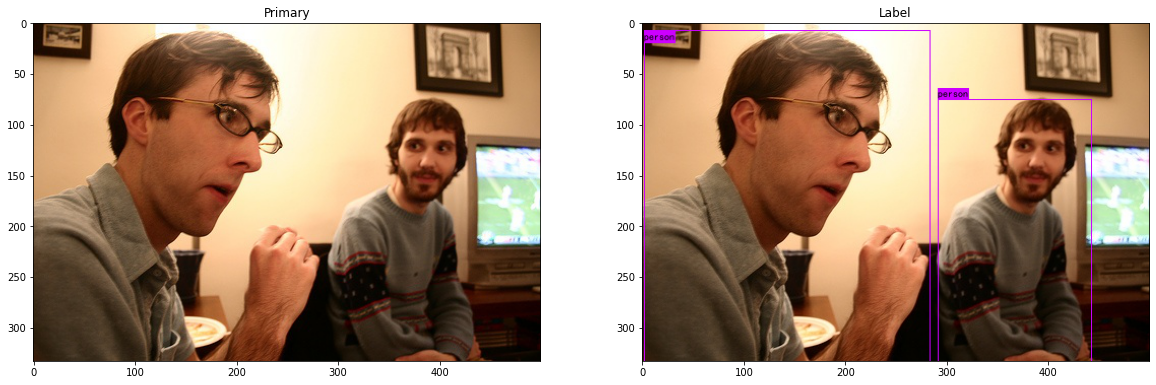

In [3]:
# 显示图像和标签
import matplotlib.pyplot as plt
from PIL import Image
img0 = Image.open('images/000104.jpg')
img1 = Image.open('images/000104_label.png')
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title('Primary')
plt.imshow(img0)
plt.subplot(1, 2, 2)
plt.title('Label')
plt.imshow(img1)
plt.show()

### 数据预处理

首先需要检查标签文件是否非空，获取到的标签是否有效，然后需要对数据进行处理使其符合网络输入的格式，比如网络需要输入的是(batch,c,h,w)形式的Tensor数据，那么就需要将batch张(h,w,c)的数据进行包装并且归一化转成Tensor数据结构后才能输入。此外，为了提升网络对于数据的利用率，将数据进行mosaic数据增强。

#### 检查文件

定义函数以便筛除无效标签。

In [4]:
from pycocotools.coco import COCO
import random
import numpy as np
import os
import multiprocessing
import cv2
from PIL import Image
import mindspore.dataset as ds
def has_valid_annotation(anno):
    """Check annotation file."""
    # if it's empty, there is no annotation
    if not anno:
        return False
    # if all boxes have close to zero area, there is no annotation
    if _has_only_empty_bbox(anno):
        return False
    # keypoints task have a slight different criteria for considering
    # if an annotation is valid
    if "keypoints" not in anno[0]:
        return True
    # for keypoint detection tasks, only consider valid images those
    # containing at least min_keypoints_per_image
    if _count_visible_keypoints(anno) >= min_keypoints_per_image:
        return True
    return False
def _has_only_empty_bbox(anno):
    return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)
def _count_visible_keypoints(anno):
    return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)

#### 数据集增强

使用mosaic数据增强的方式，来丰富数据集，增加网络的鲁棒性。

In [5]:
class COCOYoloDataset:
    """YOLOV5 Dataset for COCO."""
    def __init__(self, root, ann_file, remove_images_without_annotations=True,
                 filter_crowd_anno=True, is_training=True):
        self.coco = COCO(ann_file)
        self.root = root
        self.img_ids = list(sorted(self.coco.imgs.keys()))
        self.filter_crowd_anno = filter_crowd_anno
        self.is_training = is_training
        self.mosaic = True
        # filter images without any annotations
        if remove_images_without_annotations:
            img_ids = []
            for img_id in self.img_ids:
                ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
                anno = self.coco.loadAnns(ann_ids)
                if has_valid_annotation(anno):
                    img_ids.append(img_id)
            self.img_ids = img_ids

        self.categories = {cat["id"]: cat["name"] for cat in self.coco.cats.values()}

        self.cat_ids_to_continuous_ids = {
            v: i for i, v in enumerate(self.coco.getCatIds())
        }
        self.continuous_ids_cat_ids = {
            v: k for k, v in self.cat_ids_to_continuous_ids.items()
        }
        self.count = 0

    def _mosaic_preprocess(self, index, input_size):
        labels4 = []
        s = 384
        self.mosaic_border = [-s // 2, -s // 2]
        yc, xc = [int(random.uniform(-x, 2 * s + x)) for x in self.mosaic_border]
        indices = [index] + [random.randint(0, len(self.img_ids) - 1) for _ in range(3)]
        for i, img_ids_index in enumerate(indices):
            coco = self.coco
            img_id = self.img_ids[img_ids_index]
            img_path = coco.loadImgs(img_id)[0]["file_name"]
            img = Image.open(os.path.join(self.root, img_path)).convert("RGB")
            img = np.array(img)
            h, w = img.shape[:2]

            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 128, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

            padw = x1a - x1b
            padh = y1a - y1b

            ann_ids = coco.getAnnIds(imgIds=img_id)
            target = coco.loadAnns(ann_ids)
            # filter crowd annotations
            if self.filter_crowd_anno:
                annos = [anno for anno in target if anno["iscrowd"] == 0]
            else:
                annos = [anno for anno in target]

            target = {}
            boxes = [anno["bbox"] for anno in annos]
            target["bboxes"] = boxes

            classes = [anno["category_id"] for anno in annos]
            classes = [self.cat_ids_to_continuous_ids[cl] for cl in classes]
            target["labels"] = classes

            bboxes = target['bboxes']
            labels = target['labels']
            out_target = []

            for bbox, label in zip(bboxes, labels):
                tmp = []
                # convert to [x_min y_min x_max y_max]
                bbox = self._convetTopDown(bbox)
                tmp.extend(bbox)
                tmp.append(int(label))
                # tmp [x_min y_min x_max y_max, label]
                out_target.append(tmp)  # 这里out_target是label的实际宽高，对应于图片中的实际度量

            labels = out_target.copy()
            labels = np.array(labels)
            out_target = np.array(out_target)

            labels[:, 0] = out_target[:, 0] + padw
            labels[:, 1] = out_target[:, 1] + padh
            labels[:, 2] = out_target[:, 2] + padw
            labels[:, 3] = out_target[:, 3] + padh
            labels4.append(labels)

        if labels4:
            labels4 = np.concatenate(labels4, 0)
            np.clip(labels4[:, :4], 0, 2 * s, out=labels4[:, :4])  # use with random_perspective
        flag = np.array([1])
        return img4, labels4, input_size, flag

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            (img, target) (tuple): target is a dictionary contains "bbox", "segmentation" or "keypoints",
                generated by the image's annotation. img is a PIL image.
        """
        coco = self.coco
        img_id = self.img_ids[index]
        img_path = coco.loadImgs(img_id)[0]["file_name"]
        if not self.is_training:
            img = Image.open(os.path.join(self.root, img_path)).convert("RGB")
            return img, img_id

        input_size = [640, 640]
        if self.mosaic and random.random() < 0.5:
            return self._mosaic_preprocess(index, input_size)
        img = np.fromfile(os.path.join(self.root, img_path), dtype='int8')
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)
        # filter crowd annotations
        if self.filter_crowd_anno:
            annos = [anno for anno in target if anno["iscrowd"] == 0]
        else:
            annos = [anno for anno in target]

        target = {}
        boxes = [anno["bbox"] for anno in annos]
        target["bboxes"] = boxes

        classes = [anno["category_id"] for anno in annos]
        classes = [self.cat_ids_to_continuous_ids[cl] for cl in classes]
        target["labels"] = classes

        bboxes = target['bboxes']
        labels = target['labels']
        out_target = []
        for bbox, label in zip(bboxes, labels):
            tmp = []
            # convert to [x_min y_min x_max y_max]
            bbox = self._convetTopDown(bbox)
            tmp.extend(bbox)
            tmp.append(int(label))
            # tmp [x_min y_min x_max y_max, label]
            out_target.append(tmp)
        flag = np.array([0], dtype=np.int32)
        # print(flag.dtype)
        return img, out_target, input_size, flag

    def __len__(self):
        return len(self.img_ids)

    def _convetTopDown(self, bbox):
        x_min = bbox[0]
        y_min = bbox[1]
        w = bbox[2]
        h = bbox[3]
        return [x_min, y_min, x_min+w, y_min+h]

### 创建数据集

定义创建数据集的`create_yolo_dataset`方法，具体代码如下：

In [6]:
import mindspore.dataset as ds
import os
from src.distributed_sampler import DistributedSampler
import multiprocessing
from src.transforms import reshape_fn, MultiScaleTrans, PreprocessTrueBox
def create_yolo_dataset(image_dir, anno_path, batch_size, device_num, rank,
                        config=None, is_training=True, shuffle=True):
    """Create dataset for YOLOV5."""
    cv2.setNumThreads(0)
    ds.config.set_enable_shared_mem(True)
    if is_training:
        filter_crowd = True
        remove_empty_anno = True
    else:
        filter_crowd = False
        remove_empty_anno = False

    yolo_dataset = COCOYoloDataset(root=image_dir, ann_file=anno_path, filter_crowd_anno=filter_crowd,
                                   remove_images_without_annotations=remove_empty_anno, is_training=is_training)
    distributed_sampler = DistributedSampler(len(yolo_dataset), device_num, rank, shuffle=shuffle)
    yolo_dataset.size = len(distributed_sampler)
#     hwc_to_chw = ds.vision.c_transforms.HWC2CHW() #1.7
    hwc_to_chw = ds.vision.HWC2CHW()
    config.dataset_size = len(yolo_dataset)
    cores = multiprocessing.cpu_count()
    num_parallel_workers = int(cores / device_num)
    num_parallel_workers = config.num_parallel_workers
    if is_training:
        multi_scale_trans = MultiScaleTrans(config, device_num)
        yolo_dataset.transforms = multi_scale_trans

        dataset_column_names = ["image", "annotation", "input_size", "mosaic_flag"]
        output_column_names = ["image", "annotation", "bbox1", "bbox2", "bbox3",
                               "gt_box1", "gt_box2", "gt_box3"]
        map1_out_column_names = ["image", "annotation", "size"]
        map2_in_column_names = ["annotation", "size"]
        map2_out_column_names = ["annotation", "bbox1", "bbox2", "bbox3",
                                 "gt_box1", "gt_box2", "gt_box3"]
        dataset = ds.GeneratorDataset(yolo_dataset, column_names=dataset_column_names, sampler=distributed_sampler,
                                      python_multiprocessing=False, num_parallel_workers=1)
        dataset = dataset.map(operations=multi_scale_trans, input_columns=dataset_column_names,
                              output_columns=map1_out_column_names, column_order=map1_out_column_names,
                              num_parallel_workers=1, python_multiprocessing=False)
        dataset = dataset.map(operations=PreprocessTrueBox(config), input_columns=map2_in_column_names,
                              output_columns=map2_out_column_names, column_order=output_column_names,
                              num_parallel_workers=1, python_multiprocessing=False)
        mean = [m * 255 for m in [0.485, 0.456, 0.406]]
        std = [s * 255 for s in [0.229, 0.224, 0.225]]
#         dataset = dataset.map([ds.vision.c_transforms.Normalize(mean, std), hwc_to_chw],
#                               num_parallel_workers=min(4, num_parallel_workers))#1.7
        dataset = dataset.map([ds.vision.Normalize(mean, std), hwc_to_chw],
                              num_parallel_workers=min(4, num_parallel_workers))
        def concatenate(images):
            images = np.concatenate((images[..., ::2, ::2], images[..., 1::2, ::2],
                                     images[..., ::2, 1::2], images[..., 1::2, 1::2]), axis=0)
            return images
        dataset = dataset.map(operations=concatenate, input_columns="image",
                              num_parallel_workers=min(4, num_parallel_workers))
        dataset = dataset.batch(batch_size, num_parallel_workers=min(4, num_parallel_workers), drop_remainder=True)
    else:
        dataset = ds.GeneratorDataset(yolo_dataset, column_names=["image", "img_id"],
                                      sampler=distributed_sampler)
        compose_map_func = (lambda image, img_id: reshape_fn(image, img_id, config))
        dataset = dataset.map(operations=compose_map_func, input_columns=["image", "img_id"],
                              output_columns=["image", "image_shape", "img_id"],
                              column_order=["image", "image_shape", "img_id"],
                              num_parallel_workers=8)
        dataset = dataset.map(operations=hwc_to_chw, input_columns=["image"], num_parallel_workers=8)
        dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

具体实现代码如下

In [7]:
import cv2
from src.config import config
# config.data_root = r'G:/models-r1.7/official/cv/yolov5/data/coco/val2017'
# config.data_path = r'G:/models-r1.7/official/cv/yolov5/data/coco/annotations/instances_val2017.json'
# config.annFile = os.path.join(config.data_dir, 'annotations/instances_val2017.json')
# config.data_root = r'G:\models-r1.7voc\official\cv\yolov5\VOCdevkit\VOC2007\JPEGImages'
# config.data_path = r'G:\models-r1.7voc\official\cv\yolov5\test.json'
# config.annFile = r'G:\models-r1.7voc\official\cv\yolov5\test.json'
config.data_root = './minivoc/images'
config.data_path = './minivoc/train.json'
config.annFile = './minivoc/train.json'
# config.annFile = config.data_path
ds = create_yolo_dataset(image_dir=config.data_root, anno_path=config.annFile, is_training=True,
                         batch_size=config.per_batch_size, device_num=config.group_size,
                         rank=config.rank, config=config)

[WARNING] ME(164353:281473386010496,MainProcess):2022-10-20-17:20:08.186.497 [mindspore/dataset/core/config.py:635] The shared memory is on, multiprocessing performance will be improved. Note: the required shared memory can't exceeds 80% of the available shared memory.


{'data_dir': 'Train dataset directory.', 'per_batch_size': 'Batch size for Training.', 'pretrained_backbone': 'The ckpt file of CspDarkNet53.', 'resume_yolov5': 'The ckpt file of YOLOv5, which used to fine tune.', 'pretrained_checkpoint': 'The ckpt file of YOLOv5CspDarkNet53.', 'lr_scheduler': 'Learning rate scheduler, options: exponential, cosine_annealing.', 'lr': 'Learning rate.', 'lr_epochs': "Epoch of changing of lr changing, split with ','.", 'lr_gamma': 'Decrease lr by a factor of exponential lr_scheduler.', 'eta_min': 'Eta_min in cosine_annealing scheduler.', 'T_max': 'T-max in cosine_annealing scheduler.', 'max_epoch': 'Max epoch num to train the model.', 'warmup_epochs': 'Warmup epochs.', 'weight_decay': 'Weight decay factor.', 'momentum': 'Momentum.', 'loss_scale': 'Static loss scale.', 'label_smooth': 'Whether to use label smooth in CE.', 'label_smooth_factor': 'Smooth strength of original one-hot.', 'log_interval': 'Logging interval steps.', 'ckpt_path': 'Checkpoint save l

## 网络构建

网络的整体构建主要分为Backbone，和Detect两个部分。其中Backbone负责提取图片的特征图，而Detect部分负责继续增强提炼特征并进行目标的分类和定位工作。

### Backbone构建

Backbone可以被称作yolov5的主干特征提取网络，根据它的结构以及之前Yolo主干的叫法，我一般叫它CSPDarknet，输入的图片首先会在CSPDarknet里面进行特征提取，提取到的特征可以被称作特征层，是输入图片的特征集合。在主干部分，我们获取了三个特征层进行下一步网络的构建，这三个特征层我称它为有效特征层。

Backbone的结构比较复杂，我们需要将其拆分讲解，这里面包括了Conv模块，Bottleneck模块，BottleneckCSP模块，SPP模块，Focus模块。

#### Conv模块

Conv模块是网络的最基本组成部分，由于现阶段的目标检测网络深度大，为了防止梯度爆炸或者弥散现象的发生采取了各种措施，其中Yolov5中使用了Bn层和Silu激活函数加以优化。其中算法的前期主干网络提取特征的部分，卷积的stride为2这样做的目的是减小特征图的大小，不断抽象出有意义的特征的同时减少后续网络的计算量。与之不同，网络后期detect的部分卷积的stride为1，不再减小特征图的尺寸。

<div align="center">
    <img src="./images/Conv结构.jpg" width="60%" height="50%" />
</div>

In [8]:
import mindspore.nn as nn
import mindspore.ops as ops
class Conv(nn.Cell):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=None,
                 dilation=1,
                 alpha=0.1,
                 momentum=0.97,
                 eps=1e-3,
                 pad_mode="same",
                 act=True):  # ch_in, ch_out, kernel, stride, padding
        super(Conv, self).__init__()
        self.padding = auto_pad(k, p)
        self.pad_mode = None
        if self.padding == 0:
            self.pad_mode = 'same'
        elif self.padding == 1:
            self.pad_mode = 'pad'
        self.conv = nn.Conv2d(
            c1,
            c2,
            k,
            s,
            padding=self.padding,
            pad_mode=self.pad_mode,
            has_bias=False)
        self.bn = nn.BatchNorm2d(c2, momentum=momentum, eps=eps)
        self.act = SiLU() if act is True else (
            act if isinstance(act, nn.Cell) else ops.Identity())

    def construct(self, x):
        return self.act(self.bn(self.conv(x)))


#### Bottleneck

Bottleneck是主干网络中的重要组件，是一种类似于resnet中的残差网络结构。这样做的目的是为了保留部分原始特征，以免一些有意义的特征再网络的特征提取阶段被忽略。

<div align="center">
    <img src="./images/bottleneck.jpg" width="60%" height="50%" />
</div>

In [9]:
class Bottleneck(nn.Cell):
    # Standard bottleneck
    # ch_in, ch_out, shortcut, groups, expansion
    def __init__(self, c1, c2, shortcut=True, e=0.5):
        super(Bottleneck, self).__init__()
        c_ = int(c2 * e)  # hidden channels
        self.conv1 = Conv(c1, c_, 1, 1)
        self.conv2 = Conv(c_, c2, 3, 1)
        self.add = shortcut and c1 == c2

    def construct(self, x):
        c1 = self.conv1(x)
        c2 = self.conv2(c1)
        out = c2
        if self.add:
            out = x + out
        return out

#### BottleneckCSP

BottleneckCSP是网络的核心组件，它在两个分支里都利用Conv提取特征后，在其中一个分支继续使用$n^*$个Bottleneck模块进行特征抽象。之后将两个分支concat之后进行卷积。

<div align="center">
    <img src="./images/C3.jpg" width="60%" height="50%" />
</div>

In [10]:
class BottleneckCSP(nn.Cell):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, e=0.5):
        super(BottleneckCSP, self).__init__()
        c_ = int(c2 * e)  # hidden channels
        self.conv1 = Conv(c1, c_, 1, 1)
        self.conv2 = Conv(c1, c_, 1, 1)
        self.conv3 = Conv(2 * c_, c2, 1)  # act=FReLU(c2)
        self.m = nn.SequentialCell(
            [Bottleneck(c_, c_, shortcut, e=1.0) for _ in range(n)])
        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        c1 = self.conv1(x)
        c2 = self.m(c1)
        c3 = self.conv2(x)
        c4 = self.concat((c2, c3))
        c5 = self.conv3(c4)

        return c5

#### SPP

SPP 模块，包含两个标准卷积模块和 3 个最大池化层。先使用一个标准卷积模块将 channel 数减少，然后将其通过多个个不同尺度最大池化层后，将其他们与未池化的数据 Concat 到一起，再经过一个标准卷积模块将 channel 数还原到输出值。

<div align="center">
    <img src="./images/SPP.jpg" width="60%" height="50%" />
</div>

In [11]:
class SPP(nn.Cell):
    # Spatial pyramid pooling layer used in YOLOv3-SPP
    def __init__(self, c1, c2, k=(5, 9, 13)):
        super(SPP, self).__init__()
        c_ = c1 // 2  # hidden channels
        self.conv1 = Conv(c1, c_, 1, 1)
        self.conv2 = Conv(c_ * (len(k) + 1), c2, 1, 1)

        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=1, pad_mode='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=9, stride=1, pad_mode='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=13, stride=1, pad_mode='same')
        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        c1 = self.conv1(x)
        m1 = self.maxpool1(c1)
        m2 = self.maxpool2(c1)
        m3 = self.maxpool3(c1)
        c4 = self.concat((c1, m1, m2, m3))
        c5 = self.conv2(c4)
        return c5

#### Focus

Focus 模块，将输出的每一个 channel 进行切片后 Concat 到一起，再使用一个标准卷积模块进行输出。

<div align="center">
    <img src="./images/Focus.jpg" width="60%" height="50%" />
</div>

In [12]:
class Focus(nn.Cell):
    # Focus wh information into c-space
    def __init__(self, c1, c2, k=1, s=1, p=None, act=True):
        super(Focus, self).__init__()
        self.conv = Conv(c1 * 4, c2, k, s, p, act)

    def construct(self, x):
        c1 = self.conv(x)
        return c1


class SiLU(nn.Cell):
    def __init__(self):
        super(SiLU, self).__init__()
        self.sigmoid = ops.Sigmoid()

    def construct(self, x):
        return x * self.sigmoid(x)


def auto_pad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p




#### Backbone实现代码

<div align="center">
    <img src="./images/backbone.jpg" width="60%" height="50%" />
</div>

Backbone的整体结构如上图所示，首先输入的图像数据经过focus模块进行切片操作降低图像的宽高，然后经过多轮conv和C3以及一个SPP模块进一步压缩特征图的宽高，最终backbone的第5，7，10个模块输出的有效特征图将被Detect部分利用到。

In [13]:
class YOLOv5Backbone(nn.Cell):
    def __init__(self, shape):
        super(YOLOv5Backbone, self).__init__()
        self.focus = Focus(shape[0], shape[1], k=3, s=1)
        self.conv1 = Conv(shape[1], shape[2], k=3, s=2)
        self.CSP1 = BottleneckCSP(shape[2], shape[2], n=1 * shape[6])
        self.conv2 = Conv(shape[2], shape[3], k=3, s=2)
        self.CSP2 = BottleneckCSP(shape[3], shape[3], n=3 * shape[6])
        self.conv3 = Conv(shape[3], shape[4], k=3, s=2)
        self.CSP3 = BottleneckCSP(shape[4], shape[4], n=3 * shape[6])
        self.conv4 = Conv(shape[4], shape[5], k=3, s=2)
        self.spp = SPP(shape[5], shape[5], k=[5, 9, 13])
        self.CSP4 = BottleneckCSP(shape[5], shape[5], n=1 * shape[6], shortcut=False)

    def construct(self, x):
        """construct method"""
        c1 = self.focus(x)
        c2 = self.conv1(c1)
        c3 = self.CSP1(c2)
        c4 = self.conv2(c3)
        # out
        c5 = self.CSP2(c4)
        c6 = self.conv3(c5)
        # out
        c7 = self.CSP3(c6)
        c8 = self.conv4(c7)
        c9 = self.spp(c8)
        # out
        c10 = self.CSP4(c9)
        return c5, c7, c10

### Detect部分

这部分主要包含两个功能：

+ 首先是加强特征提取网络，在主干部分获得的三个有效特征层会在这一部分进行特征融合，特征融合的目的是结合不同尺度的特征信息。用于利用bacbone提取出的不同深度的特征图来在小中大三个尺度上对目标进行分类定位。

+ 分类器与回归器，通过主干网络和加强特征提取网络，我们已经可以获得三个加强过的有效特征层。每一个特征层都有宽、高和通道数，此时我们可以将特征图看作一个又一个特征点的集合，每一个特征点都有通道数个特征。Yolo Head实际上所做的工作就是对特征点进行判断，判断特征点是否有物体与其对应。与以前版本的Yolo一样，YoloV5所用的解耦头是一起的，也就是分类和回归在一个1X1卷积里实现。


#### YoloBlock

YoloBlock是一个之前Conv的stride为1的版本，用在检测头部分。是最基本的组件之一，其结构如下图左侧所示。

<div align="center">
    <img src="./images/Conv结构.jpg" width="60%" height="50%" />
</div>

In [14]:
class YoloBlock(nn.Cell):
    """
    YoloBlock for YOLOv5.

    Args:
        in_channels: Integer. Input channel.
        out_channels: Integer. Output channel.

    Returns:
        Tuple, tuple of output tensor,(f1,f2,f3).

    Examples:
        YoloBlock(12, 255)

    """
    def __init__(self, in_channels, out_channels):
        super(YoloBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, has_bias=True)

    def construct(self, x):
        """construct method"""

        out = self.conv(x)
        return out

#### YOLO模块

这部分包含了backbone以及特征增强部分。其中特征增强网络结构如图所示。首先通过backbone网络提取出三种不同程度的特征图feature_map1, feature_map2, feature_map3。然后不仅会对特征进行上采样实现特征融合，还会对特征再次进行下采样实现特征融合。值得注意的是这里的下采样使用的是stride为2的conv模块进行代替，这样做的目的是可以最大程度保留特征图的语义信息。

<div align="center">
    <img src="./images/neck.jpg" width="80%" height="50%" />
</div>

In [15]:
class YOLO(nn.Cell):
    def __init__(self, backbone, shape):
        super(YOLO, self).__init__()
        self.backbone = backbone
        self.config = default_config
        self.config.out_channel = (self.config.num_classes + 5) * 3

        self.conv1 = Conv(shape[5], shape[4], k=1, s=1)
        self.CSP5 = BottleneckCSP(shape[5], shape[4], n=1*shape[6], shortcut=False)
        self.conv2 = Conv(shape[4], shape[3], k=1, s=1)
        self.CSP6 = BottleneckCSP(shape[4], shape[3], n=1*shape[6], shortcut=False)
        self.conv3 = Conv(shape[3], shape[3], k=3, s=2)
        self.CSP7 = BottleneckCSP(shape[4], shape[4], n=1*shape[6], shortcut=False)
        self.conv4 = Conv(shape[4], shape[4], k=3, s=2)
        self.CSP8 = BottleneckCSP(shape[5], shape[5], n=1*shape[6], shortcut=False)
        self.back_block1 = YoloBlock(shape[3], self.config.out_channel)
        self.back_block2 = YoloBlock(shape[4], self.config.out_channel)
        self.back_block3 = YoloBlock(shape[5], self.config.out_channel)

        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        """
        input_shape of x is (batch_size, 3, h, w)
        feature_map1 is (batch_size, backbone_shape[2], h/8, w/8)
        feature_map2 is (batch_size, backbone_shape[3], h/16, w/16)
        feature_map3 is (batch_size, backbone_shape[4], h/32, w/32)
        """
        img_height = x.shape[2] * 2
        img_width = x.shape[3] * 2

        feature_map1, feature_map2, feature_map3 = self.backbone(x)

        c1 = self.conv1(feature_map3)
        ups1 = ops.ResizeNearestNeighbor((img_height // 16, img_width // 16))(c1)
        c2 = self.concat((ups1, feature_map2))
        c3 = self.CSP5(c2)
        c4 = self.conv2(c3)
        ups2 = ops.ResizeNearestNeighbor((img_height // 8, img_width // 8))(c4)
        c5 = self.concat((ups2, feature_map1))
        # out
        c6 = self.CSP6(c5)
        c7 = self.conv3(c6)

        c8 = self.concat((c7, c4))
        # out
        c9 = self.CSP7(c8)
        c10 = self.conv4(c9)
        c11 = self.concat((c10, c1))
        # out
        c12 = self.CSP8(c11)
        small_object_output = self.back_block1(c6)
        medium_object_output = self.back_block2(c9)
        big_object_output = self.back_block3(c12)
        return small_object_output, medium_object_output, big_object_output

#### DetectionBlock模块

DectectionBlock也就是网络的head部分，实际上是网络的分类与回归器。用于将网络提取的特征进行解码得到网络的预测结果，包括预测框的中心点坐标，宽高，置信度，种类。

In [16]:
from src.config import config as default_config

class DetectionBlock(nn.Cell):
    """
     YOLOv5 detection Network. It will finally output the detection result.

     Args:
         scale: Character.
         config: config, Configuration instance.
         is_training: Bool, Whether train or not, default True.

     Returns:
         Tuple, tuple of output tensor,(f1,f2,f3).

     Examples:
         DetectionBlock(scale='l',stride=32)
     """

    def __init__(self, scale, config=default_config, is_training=True):
        super(DetectionBlock, self).__init__()
        self.config = config
        if scale == 's':
            idx = (0, 1, 2)
            self.scale_x_y = 1.2
            self.offset_x_y = 0.1
        elif scale == 'm':
            idx = (3, 4, 5)
            self.scale_x_y = 1.1
            self.offset_x_y = 0.05
        elif scale == 'l':
            idx = (6, 7, 8)
            self.scale_x_y = 1.05
            self.offset_x_y = 0.025
        else:
            raise KeyError("Invalid scale value for DetectionBlock")
        self.anchors = ms.Tensor([self.config.anchor_scales[i] for i in idx], ms.float32)
        self.num_anchors_per_scale = 3
        self.num_attrib = 4+1+self.config.num_classes
        self.lambda_coord = 1

        self.sigmoid = nn.Sigmoid()
        self.reshape = ops.Reshape()
        self.tile = ops.Tile()
        self.concat = ops.Concat(axis=-1)
        self.pow = ops.Pow()
        self.transpose = ops.Transpose()
        self.exp = ops.Exp()
        self.conf_training = is_training

    def construct(self, x, input_shape):
        """construct method"""
        num_batch = x.shape[0]
        grid_size = x.shape[2:4]

        # Reshape and transpose the feature to [n, grid_size[0], grid_size[1], 3, num_attrib]
        prediction = self.reshape(x, (num_batch,
                                      self.num_anchors_per_scale,
                                      self.num_attrib,
                                      grid_size[0],
                                      grid_size[1]))
        prediction = self.transpose(prediction, (0, 3, 4, 1, 2))

        grid_x = ms.numpy.arange(grid_size[1])
        grid_y = ms.numpy.arange(grid_size[0])
        # Tensor of shape [grid_size[0], grid_size[1], 1, 1] representing the coordinate of x/y axis for each grid
        # [batch, gridx, gridy, 1, 1]
        grid_x = self.tile(self.reshape(grid_x, (1, 1, -1, 1, 1)), (1, grid_size[0], 1, 1, 1))
        grid_y = self.tile(self.reshape(grid_y, (1, -1, 1, 1, 1)), (1, 1, grid_size[1], 1, 1))
        # Shape is [grid_size[0], grid_size[1], 1, 2]
        grid = self.concat((grid_x, grid_y))

        box_xy = prediction[:, :, :, :, :2]
        box_wh = prediction[:, :, :, :, 2:4]
        box_confidence = prediction[:, :, :, :, 4:5]
        box_probs = prediction[:, :, :, :, 5:]

        # gridsize1 is x
        # gridsize0 is y
        box_xy = (self.scale_x_y * self.sigmoid(box_xy) - self.offset_x_y + grid) / \
                 ops.cast(ops.tuple_to_array((grid_size[1], grid_size[0])), ms.float32)
        # box_wh is w->h
        box_wh = self.exp(box_wh) * self.anchors / input_shape

        box_confidence = self.sigmoid(box_confidence)
        box_probs = self.sigmoid(box_probs)

        if self.conf_training:
            return prediction, box_xy, box_wh
        return self.concat((box_xy, box_wh, box_confidence, box_probs))

### YOLOv5总体实现

包含了网络的全部结构，其输出为预测值。图像首先经过backbone网络提取到三个有效特征层，然后经过YOLO模块得到三个特征增强有效特征层。最后利用detectionblock进行分类回归定位。

In [17]:
class YOLOV5(nn.Cell):
    """
    YOLOV5 network.

    Args:
        is_training: Bool. Whether train or not.

    Returns:
        Cell, cell instance of YOLOV5 neural network.

    Examples:
        YOLOV5s(True)
    """

    def __init__(self, is_training, version=0):
        super(YOLOV5, self).__init__()
        self.config = default_config

        # YOLOv5 network
        self.shape = self.config.input_shape[version]
        self.feature_map = YOLO(backbone=YOLOv5Backbone(shape=self.shape), shape=self.shape)

        # prediction on the default anchor boxes
        self.detect_1 = DetectionBlock('l', is_training=is_training)
        self.detect_2 = DetectionBlock('m', is_training=is_training)
        self.detect_3 = DetectionBlock('s', is_training=is_training)

    def construct(self, x, input_shape):
        small_object_output, medium_object_output, big_object_output = self.feature_map(x)
        output_big = self.detect_1(big_object_output, input_shape)
        output_me = self.detect_2(medium_object_output, input_shape)
        output_small = self.detect_3(small_object_output, input_shape)
        # big is the final output which has smallest feature map
        return output_big, output_me, output_small

## 模型训练

接下来进行模型训练，yolov5模型训练可以分为：定义损失函数、优化器以及加载预训练模型并进行训练。

### 损失函数

通过YoloLossBlock模块可以根据输入的‘s’，‘m’，‘l’对三个尺度的预测结果分别定义不同的损失函数。
首先定义IOU损失函数以及GIOU损失函数。IOU实际上就是预测框与真实框的交并比值。IOU损失函数就是1-IOU，用来反映预测框与真实框的重合程度。

GIOU是IOU的升级版，想要计算GIOU，要经过一下三个步骤：

（1）首先对于两个需要计算IOU的对象A和B,找到一个最小的集合C能囊括A和B，

（2）然后按照常规先计算A和B的IOU，

（3）使用IOU减去 {（集合C中既不属于A也不属于B的部分）/集合C的总面积}

也就是说，GIOU最大只能和IOU相等，不会大于IOU，同时，其最小值也不会小于-1，当且仅当两BOX a和b 相隔很远且IOU为0时才接近-1。由此可知，GIOU位于区间（-1，1]内。这样GIOU的大小就可以很好的衡量box的预测准确与否，同时也解决了IOU为零时的优化方向问题，使得GIOU 尽可能大就好并且它也具有IOU原本的尺度不变性的优点。

<div align="center">
    <img src="./images/giou.jpg" width="60%" height="50%" />
</div>

定义IOU损失函数

In [18]:
import mindspore.ops as ops
from src.loss import ConfidenceLoss, ClassLoss
class Iou(nn.Cell):
    """Calculate the iou of boxes"""
    def __init__(self):
        super(Iou, self).__init__()
        self.min = ops.Minimum()
        self.max = ops.Maximum()
        self.squeeze = ops.Squeeze(-1)

    def construct(self, box1, box2):
        """
        box1: pred_box [batch, gx, gy, anchors, 1,      4] ->4: [x_center, y_center, w, h]
        box2: gt_box   [batch, 1,  1,  1,       maxbox, 4]
        convert to topLeft and rightDown
        """
        box1_xy = box1[:, :, :, :, :, :2]
        box1_wh = box1[:, :, :, :, :, 2:4]
        box1_mins = box1_xy - box1_wh / ops.scalar_to_array(2.0) # topLeft
        box1_maxs = box1_xy + box1_wh / ops.scalar_to_array(2.0) # rightDown

        box2_xy = box2[:, :, :, :, :, :2]
        box2_wh = box2[:, :, :, :, :, 2:4]
        box2_mins = box2_xy - box2_wh / ops.scalar_to_array(2.0)
        box2_maxs = box2_xy + box2_wh / ops.scalar_to_array(2.0)

        intersect_mins = self.max(box1_mins, box2_mins)
        intersect_maxs = self.min(box1_maxs, box2_maxs)
        intersect_wh = self.max(intersect_maxs - intersect_mins, ops.scalar_to_array(0.0))
        # self.squeeze: for effiecient slice
        intersect_area = self.squeeze(intersect_wh[:, :, :, :, :, 0:1]) * \
                         self.squeeze(intersect_wh[:, :, :, :, :, 1:2])
        box1_area = self.squeeze(box1_wh[:, :, :, :, :, 0:1]) * \
                    self.squeeze(box1_wh[:, :, :, :, :, 1:2])
        box2_area = self.squeeze(box2_wh[:, :, :, :, :, 0:1]) * \
                    self.squeeze(box2_wh[:, :, :, :, :, 1:2])
        iou = intersect_area / (box1_area + box2_area - intersect_area)
        # iou : [batch, gx, gy, anchors, maxboxes]
        return iou

定义Giou损失函数

In [19]:
class GIou(nn.Cell):
    """Calculating giou"""
    def __init__(self):
        super(GIou, self).__init__()
        self.reshape = ops.Reshape()
        self.min = ops.Minimum()
        self.max = ops.Maximum()
        self.concat = ops.Concat(axis=1)
        self.mean = ops.ReduceMean()
        self.div = ops.RealDiv()
        self.eps = 0.000001

    def construct(self, box_p, box_gt):
        """construct method"""
        box_p_area = (box_p[..., 2:3] - box_p[..., 0:1]) * (box_p[..., 3:4] - box_p[..., 1:2])
        box_gt_area = (box_gt[..., 2:3] - box_gt[..., 0:1]) * (box_gt[..., 3:4] - box_gt[..., 1:2])
        x_1 = self.max(box_p[..., 0:1], box_gt[..., 0:1])
        x_2 = self.min(box_p[..., 2:3], box_gt[..., 2:3])
        y_1 = self.max(box_p[..., 1:2], box_gt[..., 1:2])
        y_2 = self.min(box_p[..., 3:4], box_gt[..., 3:4])
        intersection = (y_2 - y_1) * (x_2 - x_1)
        xc_1 = self.min(box_p[..., 0:1], box_gt[..., 0:1])
        xc_2 = self.max(box_p[..., 2:3], box_gt[..., 2:3])
        yc_1 = self.min(box_p[..., 1:2], box_gt[..., 1:2])
        yc_2 = self.max(box_p[..., 3:4], box_gt[..., 3:4])
        c_area = (xc_2 - xc_1) * (yc_2 - yc_1)
        union = box_p_area + box_gt_area - intersection
        union = union + self.eps
        c_area = c_area + self.eps
        iou = self.div(ops.cast(intersection, ms.float32), ops.cast(union, ms.float32))
        res_mid0 = c_area - union
        res_mid1 = self.div(ops.cast(res_mid0, ms.float32), ops.cast(c_area, ms.float32))
        giou = iou - res_mid1
        giou = ops.clip_by_value(giou, -1.0, 1.0)
        return giou
def xywh2x1y1x2y2(box_xywh):
    boxes_x1 = box_xywh[..., 0:1] - box_xywh[..., 2:3] / 2
    boxes_y1 = box_xywh[..., 1:2] - box_xywh[..., 3:4] / 2
    boxes_x2 = box_xywh[..., 0:1] + box_xywh[..., 2:3] / 2
    boxes_y2 = box_xywh[..., 1:2] + box_xywh[..., 3:4] / 2
    boxes_x1y1x2y2 = ops.Concat(-1)((boxes_x1, boxes_y1, boxes_x2, boxes_y2))
    return boxes_x1y1x2y2

#### 损失函数定义

损失函数分为三个部分：

+ 第一部分是CIOUloss，只计算正样本和对应gt框的位置关系和形状大小契合程度，该部分越小代表着预测框的位置信息越准确。

+ 第二部分是置信度损失，计算正负样本置信度confidence是否符合掩码矩阵，结果通过计算所有正样本置信度和对应gt框的置信度标签的二值交叉熵，以及所有负样本的置信度和0之间的二值交叉熵并求合表示，结果越小代表对于种类的置信度判断越准确。

+ 第三部分是类别损失，计算正样本和对应gt框种类的二至交叉熵并求合，代表的是对于种类判断的准确程度，结果越小代表判断的越准确。

<div align="center">
    <img src="./images/loss1.jpg" width="80%" height="50%" />
</div>

yolov5使用CIOU loss来衡量矩形框的损失。它将重叠面积、中心点距离、宽高比同时加入了计算。

<div align="center">
    <img src="./images/loss2.jpg" width="50%" height="50%" />
</div>

In [20]:
class YoloLossBlock(nn.Cell):
    """
    Loss block cell of YOLOV5 network.
    """
    def __init__(self, scale, config=default_config):
        super(YoloLossBlock, self).__init__()
        self.config = config
        if scale == 's':
            # anchor mask
            idx = (0, 1, 2)
        elif scale == 'm':
            idx = (3, 4, 5)
        elif scale == 'l':
            idx = (6, 7, 8)
        else:
            raise KeyError("Invalid scale value for DetectionBlock")
        self.anchors = ms.Tensor([self.config.anchor_scales[i] for i in idx], ms.float32)
        self.ignore_threshold = ms.Tensor(self.config.ignore_threshold, ms.float32)
        self.concat = ops.Concat(axis=-1)
        self.iou = Iou()
        self.reduce_max = ops.ReduceMax(keep_dims=False)
        self.confidence_loss = ConfidenceLoss()
        self.class_loss = ClassLoss()

        self.reduce_sum = ops.ReduceSum()
        self.select = ops.Select()
        self.equal = ops.Equal()
        self.reshape = ops.Reshape()
        self.expand_dims = ops.ExpandDims()
        self.ones_like = ops.OnesLike()
        self.log = ops.Log()
        self.tuple_to_array = ops.TupleToArray()
        self.g_iou = GIou()

    def construct(self, prediction, pred_xy, pred_wh, y_true, gt_box, input_shape):
        """
        prediction : origin output from yolo
        pred_xy: (sigmoid(xy)+grid)/grid_size
        pred_wh: (exp(wh)*anchors)/input_shape
        y_true : after normalize
        gt_box: [batch, maxboxes, xyhw] after normalize
        """
        object_mask = y_true[:, :, :, :, 4:5]
        class_probs = y_true[:, :, :, :, 5:]
        true_boxes = y_true[:, :, :, :, :4]

        grid_shape = prediction.shape[1:3]
        grid_shape = ops.cast(self.tuple_to_array(grid_shape[::-1]), ms.float32)

        pred_boxes = self.concat((pred_xy, pred_wh))
        true_wh = y_true[:, :, :, :, 2:4]
        true_wh = self.select(self.equal(true_wh, 0.0),
                              self.ones_like(true_wh),
                              true_wh)
        true_wh = self.log(true_wh / self.anchors * input_shape)
        # 2-w*h for large picture, use small scale, since small obj need more precise
        box_loss_scale = 2 - y_true[:, :, :, :, 2:3] * y_true[:, :, :, :, 3:4]

        gt_shape = gt_box.shape
        gt_box = self.reshape(gt_box, (gt_shape[0], 1, 1, 1, gt_shape[1], gt_shape[2]))

        # add one more dimension for broadcast
        iou = self.iou(self.expand_dims(pred_boxes, -2), gt_box)
        # gt_box is x,y,h,w after normalize
        # [batch, grid[0], grid[1], num_anchor, num_gt]
        best_iou = self.reduce_max(iou, -1)
        # [batch, grid[0], grid[1], num_anchor]

        # ignore_mask IOU too small
        ignore_mask = best_iou < self.ignore_threshold
        ignore_mask = ops.cast(ignore_mask, ms.float32)
        ignore_mask = self.expand_dims(ignore_mask, -1)
        # ignore_mask backpro will cause a lot maximunGrad and minimumGrad time consume.
        # so we turn off its gradient
        ignore_mask = ops.stop_gradient(ignore_mask)

        confidence_loss = self.confidence_loss(object_mask, prediction[:, :, :, :, 4:5], ignore_mask)
        class_loss = self.class_loss(object_mask, prediction[:, :, :, :, 5:], class_probs)

        object_mask_me = self.reshape(object_mask, (-1, 1))  # [8, 72, 72, 3, 1]
        box_loss_scale_me = self.reshape(box_loss_scale, (-1, 1))
        pred_boxes_me = xywh2x1y1x2y2(pred_boxes)
        pred_boxes_me = self.reshape(pred_boxes_me, (-1, 4))
        true_boxes_me = xywh2x1y1x2y2(true_boxes)
        true_boxes_me = self.reshape(true_boxes_me, (-1, 4))
        c_iou = self.g_iou(pred_boxes_me, true_boxes_me)
        c_iou_loss = object_mask_me * box_loss_scale_me * (1 - c_iou)
        c_iou_loss_me = self.reduce_sum(c_iou_loss, ())
        loss = c_iou_loss_me * 4 + confidence_loss + class_loss
        batch_size = prediction.shape[0]
        return loss / batch_size

#### 损失函数计算

最终整个损失函数是将loss\_l，loss\_m，loss\_s 三者加权相加得到整体的损失函数后，在利用优化器对网络的模型参数进行更新。

In [21]:
class YoloWithLossCell(nn.Cell):
    """YOLOV5 loss."""
    def __init__(self, network):
        super(YoloWithLossCell, self).__init__()
        self.yolo_network = network
        self.config = default_config
        self.loss_big = YoloLossBlock('l', self.config)
        self.loss_me = YoloLossBlock('m', self.config)
        self.loss_small = YoloLossBlock('s', self.config)
        self.tenser_to_array = ops.TupleToArray()

    def construct(self, x, y_true_0, y_true_1, y_true_2, gt_0, gt_1, gt_2, input_shape):
        input_shape = x.shape[2:4]
        input_shape = ops.cast(self.tenser_to_array(input_shape) * 2, ms.float32)

        yolo_out = self.yolo_network(x, input_shape)
        loss_l = self.loss_big(*yolo_out[0], y_true_0, gt_0, input_shape)
        loss_m = self.loss_me(*yolo_out[1], y_true_1, gt_1, input_shape)
        loss_s = self.loss_small(*yolo_out[2], y_true_2, gt_2, input_shape)
        return loss_l + loss_m + loss_s * 0.2

### 网络训练前的基本设置

+ 确定硬件环境，这里使用cpu。

+ 选择算法的版本包括s、m、l、x，这里使用s版本。

+ 定义优化器，这里使用[nn.Momentum优化器](https://www.mindspore.cn/docs/zh-CN/r1.8/api_python/nn/mindspore.nn.Momentum.html?highlight=momentum)，原理可以参考论文[On the importance of initialization and momentum in deep learning](https://dl.acm.org/doi/10.5555/3042817.3043064)

+ 对模型进行初始化。

+ 对模型进行预训练模型加载。

+ 完成数据集的加载。


In [22]:
# from src.lr_scheduler import get_lr
# from src.util import AverageMeter, get_param_groups, cpu_affinity
from src.config import config
import mindspore as ms
# import mindspore.dataset as ds
import time
from src.logger import get_logger
from src.initializer import default_recurisive_init
class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f', tb_writer=None):
        self.name = name
        self.fmt = fmt
        self.reset()
        self.tb_writer = tb_writer
        self.cur_step = 1
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        if self.tb_writer is not None:
            self.tb_writer.add_scalar(self.name, self.val, self.cur_step)
        self.cur_step += 1

    def __str__(self):
        fmtstr = '{name}:{avg' + self.fmt + '}'
        return fmtstr.format(**self.__dict__)
def get_param_groups(network):
    """Param groups for optimizer."""
    decay_params = []
    no_decay_params = []
    for x in network.trainable_params():
        parameter_name = x.name
        if parameter_name.endswith('.bias'):
            # all bias not using weight decay
            no_decay_params.append(x)
        elif parameter_name.endswith('.gamma'):
            # bn weight bias not using weight decay, be carefully for now x not
            # include BN
            no_decay_params.append(x)
        elif parameter_name.endswith('.beta'):
            # bn weight bias not using weight decay, be carefully for now x not
            # include BN
            no_decay_params.append(x)
        else:
            decay_params.append(x)

    return [{'params': no_decay_params, 'weight_decay': 0.0},
            {'params': decay_params}]
def cpu_affinity(rank_id, device_num):
    """Bind CPU cores according to rank_id and device_num."""
    import psutil
    cores = psutil.cpu_count()
    if cores < device_num:
        return
    process = psutil.Process()
    used_cpu_num = cores // device_num
    rank_id = rank_id % device_num
    used_cpu_list = [i for i in range(rank_id * used_cpu_num, (rank_id + 1) * used_cpu_num)]
    process.cpu_affinity(used_cpu_list)
    print(f"==== {rank_id}/{device_num} ==== bind cpu: {used_cpu_list}")

def load_parameters(network, filename):
    # config.logger.info("yolov5 pretrained network model: %s", filename)
    param_dict = ms.load_checkpoint(filename)
    param_dict_new = {}
    for key, values in param_dict.items():
        if key.startswith('moments.'):
            continue
        elif key.startswith('yolo_network.'):
            param_dict_new[key[13:]] = values
        else:
            param_dict_new[key] = values
    ms.load_param_into_net(network, param_dict_new)
    # config.logger.info('load_model %s success', filename)
def get_device_id():
    device_id = os.getenv('DEVICE_ID', '0')
    return int(device_id)
def train_preprocess():
    if config.lr_scheduler == 'cosine_annealing' and config.max_epoch > config.T_max:
        config.T_max = config.max_epoch
#     print(str(config.lr_epochs))
#     config.lr_epochs = "220,250" #1.7
#     config.lr_epochs = list(map(int, config.lr_epochs.split(','))) #1.7
    config.lr_epochs = list(map(int, str(config.lr_epochs).split(',')))
#     config.data_root = os.path.join(config.data_dir, 'train2017')
#     config.annFile = os.path.join(config.data_dir, 'annotations/instances_train2017.json')
    # config.data_root = r'G:/models-r1.7/official/cv/yolov5/VOCdevkit/VOC2007/JPEGImages'
    # config.annFile = r'G:\models-r1.7voc\official\cv\yolov5\test.json'
    config.data_root = './minivoc/images'
    config.annFile = './minivoc/val.json'
    device_id = get_device_id()
    config.device_target = device_target_ #这里再次定义硬件
    ms.set_context(mode=ms.GRAPH_MODE, device_target=config.device_target, device_id=device_id)

    if config.is_distributed:
        # init distributed
        init_distribute()

    # for promoting performance in GPU device
    if config.device_target == "GPU" and config.bind_cpu:
        cpu_affinity(config.rank, min(config.group_size, config.device_num))

    # logger module is managed by config, it is used in other function. e.x. config.logger.info("xxx")
    config.logger = get_logger(config.output_dir, config.rank)
    config.logger.save_args(config)
train_preprocess()
dict_version = {'yolov5s': 0, 'yolov5m': 1, 'yolov5l': 2, 'yolov5x': 3}
network = YOLOV5(is_training=True, version=dict_version[config.yolov5_version])
# default is kaiming-normal
default_recurisive_init(network)
# 加载预训练权重模型
pretrained_file = 'yolov5s_ascend_v180_coco2017_official_cv_mAP37.1.ckpt' #cpu训练的话预训练模型需要改成另一个。
if os.path.isfile(pretrained_file):
    load_parameters(network, pretrained_file)
    print('have load pretrained_file')
network = YoloWithLossCell(network)
steps_per_epoch = ds.get_dataset_size()
def linear_warmup_lr(current_step, warmup_steps, base_lr, init_lr):
    """Linear learning rate."""
    lr_inc = (float(base_lr) - float(init_lr)) / float(warmup_steps)
    lr = float(init_lr) + lr_inc * current_step
    return lr
def warmup_cosine_annealing_lr(lr, steps_per_epoch, warmup_epochs, max_epoch, T_max, eta_min=0):
    """Cosine annealing learning rate."""
    base_lr = lr
    warmup_init_lr = 0
    total_steps = int(max_epoch * steps_per_epoch)
    warmup_steps = int(warmup_epochs * steps_per_epoch)

    lr_each_step = []
    for i in range(total_steps):
        last_epoch = i // steps_per_epoch
        if i < warmup_steps:
            lr = linear_warmup_lr(i + 1, warmup_steps, base_lr, warmup_init_lr)
        else:
            lr = eta_min + (base_lr - eta_min) * (1. + math.cos(math.pi * last_epoch / T_max)) / 2
        lr_each_step.append(lr)

    return np.array(lr_each_step).astype(np.float32)

def get_lr(args, steps_per_epoch):
    """generate learning rate."""
    if args.lr_scheduler == 'cosine_annealing':
        lr = warmup_cosine_annealing_lr(args.lr, steps_per_epoch, args.warmup_epochs,
                                        args.max_epoch, args.T_max, args.eta_min)
    else:
        raise NotImplementedError(args.lr_scheduler)
    return lr
lr = get_lr(config, steps_per_epoch)
opt = nn.Momentum(params=get_param_groups(network), momentum=config.momentum, learning_rate=ms.Tensor(lr),
                  weight_decay=config.weight_decay, loss_scale=config.loss_scale)
network = nn.TrainOneStepCell(network, opt, config.loss_scale // 2)
network.set_train()

data_loader = ds.create_tuple_iterator(do_copy=False)
first_step = True
t_end = time.time()
# print(t_end)

2022-10-20 17:20:11,270:INFO:Args:
2022-10-20 17:20:11,271:INFO:--> enable_modelarts: False
2022-10-20 17:20:11,272:INFO:--> data_url: 
2022-10-20 17:20:11,273:INFO:--> train_url: 
2022-10-20 17:20:11,273:INFO:--> checkpoint_url: 
2022-10-20 17:20:11,274:INFO:--> outputs_url: 
2022-10-20 17:20:11,275:INFO:--> data_path: ./minivoc/train.json
2022-10-20 17:20:11,276:INFO:--> output_path: /cache/train
2022-10-20 17:20:11,277:INFO:--> load_path: /cache/checkpoint_path
2022-10-20 17:20:11,278:INFO:--> device_target: Ascend
2022-10-20 17:20:11,279:INFO:--> need_modelarts_dataset_unzip: False
2022-10-20 17:20:11,280:INFO:--> modelarts_dataset_unzip_name: coco
2022-10-20 17:20:11,281:INFO:--> num_parallel_workers: 1
2022-10-20 17:20:11,281:INFO:--> data_dir: ./data/coco
2022-10-20 17:20:11,282:INFO:--> per_batch_size: 4
2022-10-20 17:20:11,283:INFO:--> yolov5_version: yolov5s
2022-10-20 17:20:11,284:INFO:--> pretrained_backbone: 
2022-10-20 17:20:11,285:INFO:--> resume_yolov5: 
2022-10-20 17:2

### 模型训练

如果选择cpu设备的话运行起来会比较慢，等待时间会比较长。

In [23]:
loss_meter = AverageMeter('loss')
#这里config.max_epoch=1，可以根据需要通过修改default_config.yaml文件中对应的键值做修改
for epoch_idx in range(config.max_epoch):
    for step_idx, data in enumerate(data_loader):
        images = data[0]
        input_shape = images.shape[2:4]
        input_shape = ms.Tensor(tuple(input_shape[::-1]), ms.float64)
        loss = network(images, data[2], data[3], data[4], data[5], data[6],
                       data[7], input_shape)
        loss_meter.update(loss.asnumpy())

        # it is used for loss, performance output per config.log_interval steps.
        if (epoch_idx * steps_per_epoch + step_idx) % config.log_interval == 0:
            time_used = time.time() - t_end
            if first_step:
                fps = config.per_batch_size * config.group_size / time_used
                per_step_time = time_used * 1000
                first_step = False
            else:
                fps = config.per_batch_size * config.log_interval * config.group_size / time_used
                per_step_time = time_used / config.log_interval * 1000
            config.logger.info('epoch[{}], iter[{}], {}, fps:{:.2f} imgs/sec, '
                               'lr:{}, per step time: {}ms'.format(epoch_idx + 1, step_idx + 1,
                                                                   loss_meter, fps, lr[step_idx], per_step_time))
            t_end = time.time()
            loss_meter.reset()
    if config.rank == 0:
        ckpt_name = os.path.join(config.output_dir, "yolov5_{}_{}.ckpt".format(
            epoch_idx + 1, steps_per_epoch))
        ms.save_checkpoint(network, ckpt_name)
        print('{} has been saved in {}'.format(ckpt_name, config.output_dir))

[WARNING] DEVICE(164353,ffffa12fd780,python):2022-10-20-17:21:15.943.950 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Gradients/Default/network-YoloWithLossCell/yolo_network-YOLOV5/detect_1-DetectionBlock/gradStridedSlice/StridedSliceGrad-op3936] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(164353,ffffa12fd780,python):2022-10-20-17:21:15.949.041 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Gradients/Default/network-YoloWithLossCell/yolo_network-YOLOV5/detect_1-DetectionBlock/gradStridedSlice/StridedSliceGrad-op3937] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(164353,ffffa12fd780,python):2022-10-20-17:21:15.954.033 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operato

2022-10-20 17:21:56,808:INFO:epoch[1], iter[1], loss:138.096527, fps:0.04 imgs/sec, lr:1.7857142665889114e-05, per step time: 103584.8593711853ms
./output/yolov5_1_28.ckpt has been saved in ./output


## 模型评估与检测结果可视化

模型评估使用coco官方的api进行模型评估，获取取各个iou下的平均精度AP，以及不同maxDets下的平均召回率AR。可视化则将原图和预测结果以及真值标签可视化之后的结果进行对比。

### 模型评估



In [24]:
from src.moxing_adapter import moxing_wrapper, modelarts_pre_process
import mindspore as ms
import mindspore.dataset as ds
# from src.util import DetectionEngine
from src.logger import get_logger
import time
from src.config import config
import os
import sys
from collections import defaultdict
import datetime
from pycocotools.cocoeval import COCOeval
# from src.yolo import YOLOV5
class Redirct:
    def __init__(self):
        self.content = ""

    def write(self, content):
        self.content += content

    def flush(self):
        self.content = ""
class DetectionEngine:
    """Detection engine."""

    def __init__(self, args_detection, threshold):
        self.ignore_threshold = threshold
        self.labels = args_detection.labels
        self.num_classes = len(self.labels)
        self.results = {}
        self.file_path = ''
        self.save_prefix = args_detection.output_dir
        self.ann_file = args_detection.ann_file
        self._coco = COCO(self.ann_file)
        self._img_ids = list(sorted(self._coco.imgs.keys()))
        self.det_boxes = []
        self.nms_thresh = args_detection.eval_nms_thresh
        self.multi_label = args_detection.multi_label
        self.multi_label_thresh = args_detection.multi_label_thresh
        self.coco_catids = self._coco.getCatIds()
        self.coco_catIds = args_detection.coco_ids

    def do_nms_for_results(self):
        """Get result boxes."""
        for img_id in self.results:
            for clsi in self.results[img_id]:
                dets = self.results[img_id][clsi]
                dets = np.array(dets)
                keep_index = self._diou_nms(dets, thresh=self.nms_thresh)

                keep_box = [{'image_id': int(img_id), 'category_id': int(clsi),
                             'bbox': list(dets[i][:4].astype(float)),
                             'score': dets[i][4].astype(float)} for i in keep_index]
                self.det_boxes.extend(keep_box)

    def _nms(self, predicts, threshold):
        """Calculate NMS."""
        # convert xywh -> xmin ymin xmax ymax
        x1 = predicts[:, 0]
        y1 = predicts[:, 1]
        x2 = x1 + predicts[:, 2]
        y2 = y1 + predicts[:, 3]
        scores = predicts[:, 4]

        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        order = scores.argsort()[::-1]

        reserved_boxes = []
        while order.size > 0:
            i = order[0]
            reserved_boxes.append(i)
            max_x1 = np.maximum(x1[i], x1[order[1:]])
            max_y1 = np.maximum(y1[i], y1[order[1:]])
            min_x2 = np.minimum(x2[i], x2[order[1:]])
            min_y2 = np.minimum(y2[i], y2[order[1:]])

            intersect_w = np.maximum(0.0, min_x2 - max_x1 + 1)
            intersect_h = np.maximum(0.0, min_y2 - max_y1 + 1)
            intersect_area = intersect_w * intersect_h
            ovr = intersect_area / \
                (areas[i] + areas[order[1:]] - intersect_area)

            indexes = np.where(ovr <= threshold)[0]
            order = order[indexes + 1]
        return reserved_boxes

    def _diou_nms(self, dets, thresh=0.5):
        """
        convert xywh -> xmin ymin xmax ymax
        """
        x1 = dets[:, 0]
        y1 = dets[:, 1]
        x2 = x1 + dets[:, 2]
        y2 = y1 + dets[:, 3]
        scores = dets[:, 4]
        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        order = scores.argsort()[::-1]
        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])

            w = np.maximum(0.0, xx2 - xx1 + 1)
            h = np.maximum(0.0, yy2 - yy1 + 1)
            inter = w * h
            ovr = inter / (areas[i] + areas[order[1:]] - inter)
            center_x1 = (x1[i] + x2[i]) / 2
            center_x2 = (x1[order[1:]] + x2[order[1:]]) / 2
            center_y1 = (y1[i] + y2[i]) / 2
            center_y2 = (y1[order[1:]] + y2[order[1:]]) / 2
            inter_diag = (center_x2 - center_x1) ** 2 + (center_y2 - center_y1) ** 2
            out_max_x = np.maximum(x2[i], x2[order[1:]])
            out_max_y = np.maximum(y2[i], y2[order[1:]])
            out_min_x = np.minimum(x1[i], x1[order[1:]])
            out_min_y = np.minimum(y1[i], y1[order[1:]])
            outer_diag = (out_max_x - out_min_x) ** 2 + (out_max_y - out_min_y) ** 2
            diou = ovr - inter_diag / outer_diag
            diou = np.clip(diou, -1, 1)
            inds = np.where(diou <= thresh)[0]
            order = order[inds + 1]
        return keep

    def write_result(self):
        """Save result to file."""
        import json
        t = datetime.datetime.now().strftime('_%Y_%m_%d_%H_%M_%S')
        try:
            self.file_path = self.save_prefix + '/predict' + t + '.json'
            f = open(self.file_path, 'w')
            json.dump(self.det_boxes, f)
        except IOError as e:
            raise RuntimeError("Unable to open json file to dump. What(): {}".format(str(e)))
        else:
            f.close()
            return self.file_path

    def get_eval_result(self):
        """Get eval result."""
        coco_gt = COCO(self.ann_file)
        coco_dt = coco_gt.loadRes(self.file_path)
        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        rdct = Redirct()
        stdout = sys.stdout
        sys.stdout = rdct
        coco_eval.summarize()
        sys.stdout = stdout
        return rdct.content
    def detect(self, outputs, batch, image_shape, image_id):
        """Detect boxes."""
        # output [|32, 52, 52, 3, 85| ]
        for batch_id in range(batch):
            for out_item in outputs:
                # 52, 52, 3, 85
                out_item_single = out_item[batch_id, :]
                ori_w, ori_h = image_shape[batch_id]
                img_id = int(image_id[batch_id])
                if img_id not in self.results:
                    self.results[img_id] = defaultdict(list)
                x = ori_w * out_item_single[..., 0].reshape(-1)
                y = ori_h * out_item_single[..., 1].reshape(-1)
                w = ori_w * out_item_single[..., 2].reshape(-1)
                h = ori_h * out_item_single[..., 3].reshape(-1)
                conf = out_item_single[..., 4:5]
                cls_emb = out_item_single[..., 5:]
                cls_argmax = np.expand_dims(np.argmax(cls_emb, axis=-1), axis=-1)
                x_top_left = x - w / 2.
                y_top_left = y - h / 2.
                cls_emb = cls_emb.reshape(-1, self.num_classes)
                if self.multi_label:
                    confidence = conf.reshape(-1, 1) * cls_emb
                    # create all False
                    flag = cls_emb > self.multi_label_thresh
                    flag = flag.nonzero()
                    for i, j in zip(*flag):
                        confi = confidence[i][j]
                        if confi < self.ignore_threshold:
                            continue
                        x_lefti, y_lefti = max(0, x_top_left[i]), max(0, y_top_left[i])
                        wi, hi = min(w[i], ori_w), min(h[i], ori_h)
                        # transform catId to match coco
                        coco_clsi = self.coco_catIds[j]
                        self.results[img_id][coco_clsi].append([x_lefti, y_lefti, wi, hi, confi])
                else:
                    cls_argmax = cls_argmax.reshape(-1)
                    # create all False
                    flag = np.random.random(cls_emb.shape) > sys.maxsize
                    for i in range(flag.shape[0]):
                        c = cls_argmax[i]
                        flag[i, c] = True
                    confidence = conf.reshape(-1) * cls_emb[flag]
                    for x_lefti, y_lefti, wi, hi, confi, clsi in zip(x_top_left, y_top_left,
                                                                     w, h, confidence, cls_argmax):
                        if confi < self.ignore_threshold:
                            continue
                        x_lefti, y_lefti = max(0, x_lefti), max(0, y_lefti)
                        wi, hi = min(wi, ori_w), min(hi, ori_h)
                        # transform catId to match coco
                        coco_clsi = self.coco_catids[clsi]
                        self.results[img_id][coco_clsi].append([x_lefti, y_lefti, wi, hi, confi])
    def detect_one_image(self, outputs, batch, image_shape):
        # m = 0
        for batch_id in range(batch):
            bboxs = []#对应一个图片中所有解码的bbox
            for out_item in outputs:
                # 52, 52, 3, 85
                out_item_single = out_item[batch_id, :]
                # ori_w, ori_h = image_shape[batch_id]
                ori_w, ori_h = image_shape

                # img_id = int(image_id[batch_id])
                # if img_id not in self.results:
                #     self.results[img_id] = defaultdict(list)
                x = ori_w * out_item_single[..., 0].reshape(-1)#xywh这里是bbox框中心坐标和框的宽高x的shape是19200。当out_item变化时也就是预测尺度变化时这里的shape也会跟着变
                y = ori_h * out_item_single[..., 1].reshape(-1)
                w = ori_w * out_item_single[..., 2].reshape(-1)
                h = ori_h * out_item_single[..., 3].reshape(-1)
                conf = out_item_single[..., 4:5]
                cls_emb = out_item_single[..., 5:]
                # cls_argmax = np.expand_dims(np.argmax(cls_emb, axis=-1), axis=-1)
                x_top_left = x - w / 2.
                y_top_left = y - h / 2.
                cls_emb = cls_emb.reshape(-1, self.num_classes)
                # cls_emb =cls_emb[:,0].reshape(-1,1)
                if self.multi_label:
                    confidence = conf.reshape(-1, 1) * cls_emb
                    # create all False
                    flag = cls_emb > self.multi_label_thresh
                    flag = flag.nonzero()
                    for i, j in zip(*flag):#i代表第几个预测框，j的内容是预测的种类，而且这里i可能回重复，因为一个预测框可能有多个在阈值以上的目标还存在
                        confi = confidence[i][j]
                        if confi < self.ignore_threshold:
                            continue
                        if j == 1:
                            x_lefti, y_lefti = max(0, x_top_left[i]), max(0, y_top_left[i])
                            wi, hi = min(w[i], ori_w), min(h[i], ori_h)#这里做了一些防止bug的处理，防止框的范围出图
                            x_right, y_right = min(x_lefti + wi, ori_w), min(y_lefti + hi, ori_h)
                            bboxs = bboxs + [x_lefti, y_lefti, x_right, y_right, confi]#这里是为了契合nms的要求
                            # m+=1
                            # print(m)

            self.bboxs = np.reshape(bboxs, (-1, 5))

                        # transform catId to match coco
                        # coco_clsi = self.coco_catIds[j]
                        # self.results[img_id][coco_clsi].append([x_lefti, y_lefti, wi, hi, confi])#[x_lefti, y_lefti, wi, hi, confi]这时解码后的预测框
        return self.bboxs
def eval_preprocess():
    # config.data_root = r'G:\models-r1.7voc\official\cv\yolov5\VOCdevkit\VOC2007\JPEGImages'
    # config.ann_file = r'G:\models-r1.7voc\official\cv\yolov5\val.json'
    config.data_root = './minivoc/images'
    config.ann_file = './minivoc/val.json'
    device_id = int(os.getenv('DEVICE_ID', '0'))
#     print(int(device_id))
#     ms.set_context(mode=ms.GRAPH_MODE, device_target=config.device_target, device_id=device_id)

    # logger module is managed by config, it is used in other function. e.x. config.logger.info("xxx")
    config.logger = get_logger(config.output_dir, device_id)
def load_parameters(network, filename):
    # config.logger.info("yolov5 pretrained network model: %s", filename)
    param_dict = ms.load_checkpoint(filename)
    param_dict_new = {}
    for key, values in param_dict.items():
        if key.startswith('moments.'):
            continue
        elif key.startswith('yolo_network.'):
            param_dict_new[key[13:]] = values
        else:
            param_dict_new[key] = values
    ms.load_param_into_net(network, param_dict_new)
    # config.logger.info('load_model %s success', filename)
@moxing_wrapper(pre_process=modelarts_pre_process, pre_args=[config])
def run_eval():
    eval_preprocess()
    start_time = time.time()
    config.logger.info('Creating Network....')
    dict_version = {'yolov5s': 0, 'yolov5m': 1, 'yolov5l': 2, 'yolov5x': 3}
    network = YOLOV5(is_training=False, version=dict_version[config.yolov5_version])
    config.pretrained = 'output/yolov5_1_28.ckpt'#填入训练得到的模型
    # config.pretrained = 'yolov5_1_1859.ckpt'#填入训练得到的模型

    if os.path.isfile(config.pretrained):
        load_parameters(network, config.pretrained)
    else:
        raise FileNotFoundError(f"{config.pretrained} is not a filename.")

    ds = create_yolo_dataset(config.data_root, config.ann_file, is_training=False, batch_size=config.per_batch_size,
                             device_num=1, rank=0, shuffle=False, config=config)

    config.logger.info('testing shape : %s', config.test_img_shape)
    config.logger.info('total %d images to eval', ds.get_dataset_size() * config.per_batch_size)

    network.set_train(False)

    # init detection engine
    detection = DetectionEngine(config, config.test_ignore_threshold)

    input_shape = ms.Tensor(tuple(config.test_img_shape), ms.float32)
    config.logger.info('Start inference....')
    for index, data in enumerate(ds.create_dict_iterator(output_numpy=True, num_epochs=1)):
        image = data["image"]
        # adapt network shape of input data
        image = np.concatenate((image[..., ::2, ::2], image[..., 1::2, ::2],
                                image[..., ::2, 1::2], image[..., 1::2, 1::2]), axis=1)
        image = ms.Tensor(image)#填入需要进行数据格式转化的变量
        image_shape_ = data["image_shape"]
        image_id_ = data["img_id"]
        output_big, output_me, output_small = network(image, input_shape)
        output_big = output_big.asnumpy()
        output_me = output_me.asnumpy()
        output_small = output_small.asnumpy()
        detection.detect([output_small, output_me, output_big], config.per_batch_size, image_shape_, image_id_)

        if index % 50 == 0:
            config.logger.info('Processing... {:.2f}% '.format(index / ds.get_dataset_size() * 100))

    config.logger.info('Calculating mAP...')
    detection.do_nms_for_results()
    result_file_path = detection.write_result()
    config.logger.info('result file path: %s', result_file_path)
    eval_result = detection.get_eval_result()

    cost_time = time.time() - start_time
    eval_log_string = '\n=============coco eval result=========\n' + eval_result
    config.logger.info(eval_log_string)
    config.logger.info('testing cost time %.2f h', cost_time / 3600.)
run_eval()

2022-10-20 17:21:59,423:INFO:Creating Network....


[WARNING] ME(164353:281473386010496,MainProcess):2022-10-20-17:22:01.931.11 [mindspore/dataset/core/config.py:635] The shared memory is on, multiprocessing performance will be improved. Note: the required shared memory can't exceeds 80% of the available shared memory.


loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
2022-10-20 17:22:01,582:INFO:testing shape : [640, 640]
2022-10-20 17:22:01,585:INFO:total 212 images to eval
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2022-10-20 17:22:01,596:INFO:Start inference....
2022-10-20 17:22:24,048:INFO:Processing... 0.00% 
2022-10-20 17:23:07,263:INFO:Processing... 94.34% 
2022-10-20 17:23:08,937:INFO:Calculating mAP...
2022-10-20 17:23:14,256:INFO:result file path: ./output/predict_2022_10_20_17_23_13.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.94s).
Accumulating evaluation results...
DONE (t=0.33s).
2022-10-20 17:23:16,821:INFO:
=============coco eval result=========
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] =

### 检测结果可视化

选取图片进行检测，并将检测结果可视化后与原图像和真值图片做对比。

#### 首先定义一些功能模块，包括模型加载函数、resize、归一化等

In [25]:
# from PIL import Image
import matplotlib.pyplot as plt
# import mindspore.dataset.vision as vision
import os
import numpy as np
from PIL import Image
from src.config import config
from PIL import ImageDraw, ImageFont
# from src.yolo import YOLOV5
import mindspore as ms


def load_parameters(network, filename):
    # config.logger.info("yolov5 pretrained network model: %s", filename)
    param_dict = ms.load_checkpoint(filename)
    param_dict_new = {}
    for key, values in param_dict.items():
        if key.startswith('moments.'):
            continue
        elif key.startswith('yolo_network.'):
            param_dict_new[key[13:]] = values
        else:
            param_dict_new[key] = values
    ms.load_param_into_net(network, param_dict_new)
    # config.logger.info('load_model %s success', filename)


def resize_image(image, size):
    w, h = size
    new_image = image.resize((w, h), Image.BILINEAR)
    return new_image


def preprocess_input(image):
    image /= 255.0  # 填入数字来将图像输入进行归一化
    return image
# ---------------------------------------------------------#
#   将图像转换成RGB图像，防止灰度图在预测时报错。
#   代码仅仅支持RGB图像的预测，所有其它类型的图像都会转化成RGB
# ---------------------------------------------------------#


def cvtColor(image):
    if len(np.shape(image)) == 3 and np.shape(image)[2] == 3:
        return image
    image = image.convert('RGB')
    return image

#### 检测一张图片

这里可以通过修改detect_image_path选择本地路径下的jpg图片进行检测。

In [ ]:
# from src.util import DetectionEngine
detection = DetectionEngine(config, 0.1)
dict_version = {'yolov5s': 0, 'yolov5m': 1, 'yolov5l': 2, 'yolov5x': 3}
network = YOLOV5(is_training=False, version=dict_version['yolov5s'])
pretrained_file = 'output/yolov5_1_28.ckpt'
if os.path.isfile(pretrained_file):
    load_parameters(network, pretrained_file)
detected_image_path = 'images/000104.jpg'
detected_image_name = os.path.basename(detected_image_path)
img = Image.open(detected_image_path)
image_shape = np.array(np.shape(img)[0:2])
image_shape = np.array([image_shape[1], image_shape[0]])
imagedata = cvtColor(img)
image = resize_image(imagedata, (640, 640))
image = np.expand_dims(np.transpose(preprocess_input(
    np.array(image, dtype='float32')), (2, 0, 1)), 0)
image = np.concatenate((image[..., ::2, ::2], image[..., 1::2, ::2],
                        image[..., ::2, 1::2], image[..., 1::2, 1::2]), axis=1)
image = ms.Tensor(image)
input_shape = ms.Tensor(tuple(config.test_img_shape), ms.float32)
output_big, output_me, output_small = network(image, input_shape)
output_big = output_big.asnumpy()
output_me = output_me.asnumpy()
output_small = output_small.asnumpy()
bboxs = detection.detect_one_image(
    [output_small, output_me, output_big], 1, image_shape)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


#### 对检测结果进行非极大值抑制

In [ ]:
inputs = ms.Tensor(bboxs, ms.float32)
nms = ms.ops.NMSWithMask(iou_threshold=0.5)
output_boxes, indices, mask = nms(inputs)
output_boxes = output_boxes.asnumpy()
mask = mask.asnumpy()
output_boxes = output_boxes[mask]
indices_np = indices.asnumpy()
top_boxes = output_boxes[:, :4]
top_conf = output_boxes[:, 4]

#### 设置图像字体和边框厚度并进行图像绘制

In [ ]:
font = ImageFont.truetype(font='simhei.ttf', size=np.floor(
    3e-2 * image_shape[1] + 0.5).astype('int32'))
thickness = int(
    max((image_shape[0] + image_shape[1]) // np.mean([640, 640]), 1))
for i in range(len(top_conf)):
    predicted_class = 'person'
    box = top_boxes[i]
    score = top_conf[i]

    # top, left, bottom, right = box
    left, top, right, bottom = box

    top = max(0, np.floor(top).astype('int32'))
    left = max(0, np.floor(left).astype('int32'))
    bottom = min(image_shape[1], np.floor(bottom).astype('int32'))
    right = min(image_shape[0], np.floor(right).astype('int32'))

    label = '{} {:.2f}'.format(predicted_class, score)
    # label = 'person'
    draw = ImageDraw.Draw(imagedata)
    label_size = draw.textsize(label, font)
    label = label.encode('utf-8')
    print(label, top, left, bottom, right)

    if top - label_size[1] >= 0:
        text_origin = np.array([left, top - label_size[1]])
    else:
        text_origin = np.array([left, top + 1])

    for i in range(thickness):
        draw.rectangle([left + i, top + i, right - i, bottom - i], outline=(204, 0, 255))
    draw.rectangle([tuple(text_origin), tuple(
        text_origin + label_size)], fill=(204, 0, 255))
    draw.text(text_origin, str(label, 'UTF-8'), fill=(0, 0, 0), font=font)
    del draw
dir_save_path = 'images'
result_name = 'result_' + detected_image_name
result_path = os.path.join(dir_save_path, result_name.replace(".jpg", ".png"))
print(result_path)
imagedata.save(result_path, quality=95, subsampling=0)

#### 显示图像和检测结果

显示图像和检测结果之前需要完成1.6.2的全部内容，如果需要检测其他图片可以在1.6.2.2部分对检测图片的路径进行修改。

In [ ]:
img0 = Image.open(detected_image_path)
img2 = Image.open(result_path)
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title('Primary')
plt.imshow(img0)
plt.subplot(1, 2, 2)
plt.title('Predict')
plt.imshow(img2)
plt.show()

## 实验任务

请完成模型评估与检测结果可视化章节下的程序，在'FIXME'位置填写正确内容，以保证程序正确运行。


### 参考答案

</details>
<details><summary>
    点击显示答案
    </summary>

+ 'fixme_1'：'output/yolov5_1_28.ckpt'

+ 'fixme_2'：image

+ 'fixme_3'：255.0

</details>


## 实验总结

本次实验介绍对算机视觉当中利用深度学习Yolov5网络完成人类目标检测任务。实验过程中，需学习深度学习如何进行数据增强，如何实现定义复杂的网络结构，如何训练和提升模型效果及微调训练等操作技巧。

软件环境:

+ Python 3.7.5

+ MindSpore 1.8.1